In [1]:
import os, math, copy
import matplotlib.pyplot as plt
from pybeta_asymmetry import *
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def drawdown(returns): # Calculate Drawdowns
    cumulative = returns
    highwatermark = cumulative.cummax()
    drawdown = (cumulative / highwatermark)-1
    return drawdown

def max_dd(returns): # Calculate Maxium Drawdowns
    return np.min(drawdown(returns))

def cagr(data): # Calculate CAGR
    years = data.index[-1].year - data.index[0].year
    return (data.iloc[-1] ** (1 / years)) -1
    
def sharpe(returns, days): # Calculate Sharpe Ratio
    return cagr((returns+1).cumprod()) / (np.std(returns) * np.sqrt(days))

def cum(returns): # Calculate Cummlative Returns from Returns
    return (returns+1).cumprod()

def weight_fill(raw, momentum): # Function for matching resampled data with another data
    raw.index = pd.to_datetime(raw.index)
    dummy = pd.DataFrame(pd.to_datetime(np.array(raw.index)), columns=['tmp'])
    dummy.index = raw.index
    dummy['tmp'] = pd.to_datetime(dummy.index)

    momentum.index = pd.to_datetime(momentum.index)
    momentum['tmp'] = pd.to_datetime(momentum.index)

    result = pd.merge(dummy, momentum, on='tmp', how='left')
    result.index = pd.to_datetime(result["tmp"])
    result = result.drop("tmp", axis=1)
    result = result.pad()
    return result

In [79]:
# Load US Data 
loc = os.getcwd() + "/" 
# stock = pd.read_csv(loc+"Data/CRSP_CLOSE_PP.csv", index_col="date").drop("Unnamed: 0", axis=1)
stock = pd.read_csv(loc+"Data/CRSP_CLOSE_FINAL.csv", index_col="date", date_format="%Y-%m-%d")
market = pd.read_csv(loc+"Data/SPX.csv")[["Date","Close"]]
# screen = pd.read_csv(loc+"Data/CRSP_CONSTITUENTS_PP.csv", index_col="date")
screen = pd.read_csv(loc+"Data/CRSP_CONSTITUENTS_FINAL.csv", index_col="date", date_format="%Y-%m-%d")
screen = screen.applymap(lambda x: np.nan if x==0 else (int(x) if not math.isnan(x) else np.nan))
stock = np.abs(stock)

### Preprocess Data
stock.index = pd.to_datetime(stock.index, format="%Y%m%d")
market.columns = ["date","CLOSE"]
market.index = pd.to_datetime(market["date"])
market = market.drop("date", axis=1)
screen.index = pd.to_datetime(screen.index)

for col in stock.columns:
    if col not in screen.columns:
        stock = stock.drop(col, axis=1)

for idx in market.index:
    if idx not in stock.index:
        market = market.drop(idx, axis=0)

# Calculate Stock Return
stock_return = stock.pct_change()
market_return = market.pct_change()

dummy_matrix = stock.copy()
dummy_matrix[dummy_matrix.isna() == False] = 0

stock_return = stock_return + dummy_matrix
stock_return = stock_return.dropna(how="all", axis=0)
market_return = market_return.dropna(how="all", axis=0)

# Preprocess 2
for idx in screen.index:
    if idx not in stock_return.index:
        screen = screen.drop(idx, axis=0)

In [4]:
### Winsorize the Stock Return
winsor_stock_return = PREPROCESSOR.do_winsorize(stock_return, method='quantile', quantile=0.025, hurdle=0.25)
# winsor_stock_return = PREPROCESSOR.replace_extreme(stock_return, 0.5)
# winsor_stock_return = stock_return.copy() ### When Using no preprocessed stock return

Please Wait...


Winsorizing...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:03<00:00, 1844.61it/s]


In [ ]:
# Beta Calculation - upBeta
upBeta = BETA_CALCULATOR()
upBeta.run(
    stock_return=winsor_stock_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    market_return=market_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    window=252, # int
    type="up", # str ('up', 'down', 'all')
    white=False, # White Standard Error (used in OLS only)
)
upBeta.beta = upBeta.beta * screen
upBeta.beta.to_csv(loc+"Export/us_upBeta.csv") # Save the Result

In [ ]:
# Beta Calculation - downBeta
downBeta = BETA_CALCULATOR()
downBeta.run(
    stock_return=winsor_stock_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    market_return=market_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    window=252, # int
    type="down", # str ('up', 'down', 'all')
    white=False, # White Standard Error (used in OLS only)
)
downBeta.beta = downBeta.beta * screen
downBeta.beta.to_csv(loc+"Export/us_downBeta.csv") # Save the Result

In [ ]:
plt.plot(upBeta.beta.sum(1))

In [ ]:
plt.plot(downBeta.beta.sum(1))

In [5]:
### Weight Calculation ###
upbeta_ = pd.read_csv('./Export/us_upBeta.csv', index_col='date', date_format='%Y-%m-%d')
downbeta_ = pd.read_csv('./Export/us_downBeta.csv', index_col='date', date_format='%Y-%m-%d')
myStrategy = STRATEGY()
myStrategy.straddle(
                upbeta=upbeta_,
                downbeta=downbeta_,
                long_stock_down_hurdle=0.8,
                short_stock_up_hurdle=0.8,
                up_minus_down_hurdle=0.25,
                down_minus_up_hurdle=0.25
            )

Please Wait...


Calculating short_weight...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13187.29it/s]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


In [55]:
 # Backtesting
pf_return, pf_value = backtesting_sketch(
                            stock_return = stock_return.copy(),
                            etf_return = market_return.copy(),
                            weight = myStrategy.total_weight,
                            resample = 'w-fri' # Weekly Rebalancing
)


# 모멘텀 기준을 어떻게 잡을 건지가 마지막 숙제!! 이거 잘 잡으면 성능 좋게 나올 것 같음


Calculating Momentum...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1148/1148 [00:00<00:00, 74112.07it/s]


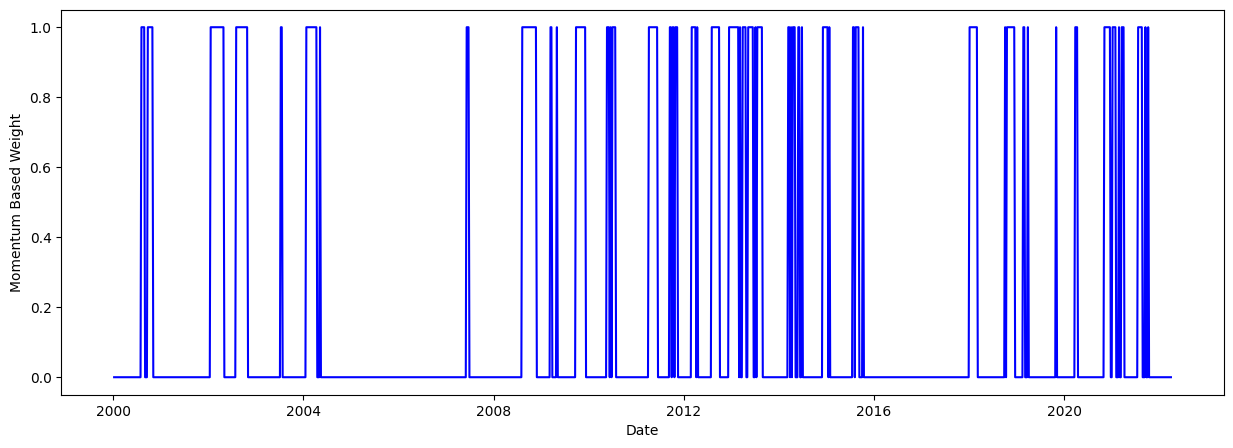

In [106]:
# Calculate Momentum Based Weight from returns of Virtual Portfolio
# Momentums are calucatled automatically without forward looking bias
mom_weight = momentum(
                pf_value = pf_value,
                lookback =13,
                method = 'hurdle_strict', hurdle=0.35)
# Plot Momentum Based Weight for Dynamic Optimization
plt.figure(figsize=(15,5))
plt.xlabel("Date", fontsize=10)
plt.ylabel("Momentum Based Weight", fontsize=10)
plt.plot(mom_weight, color='blue')

In [107]:
# Adjusted resampled weights
filled_weight = weight_fill(myStrategy.total_weight, mom_weight)
filled_weight.index = pd.to_datetime(filled_weight.index)
momStrategy = STRATEGY()
momStrategy.straddle(
    upbeta=upbeta_,
    downbeta=downbeta_,
    long_stock_down_hurdle=0.7,
    short_stock_up_hurdle=0.7,
    up_minus_down_hurdle=0.25,
    down_minus_up_hurdle=0.25,
    momentum_weight = filled_weight
)

Please Wait...
(5597,)
(5597, 1)


Calculating short_weight...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14024.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


In [108]:
momStrategy.total_weight.sum(1).describe()

count    5597.000000
mean        0.197606
std         0.398229
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

Beta-Asymmetry Strategy
CAGR: [0.12489232]
Sharpe: [0.23427527]
MDD: -0.8506278950160879
VOL: [0.53310076]

Beta-Asymmetry with strategy-based momentum
CAGR: [-0.02240846]
Sharpe: [-0.10168678]
MDD: -0.6616087653949665
VOL: [0.22036745]


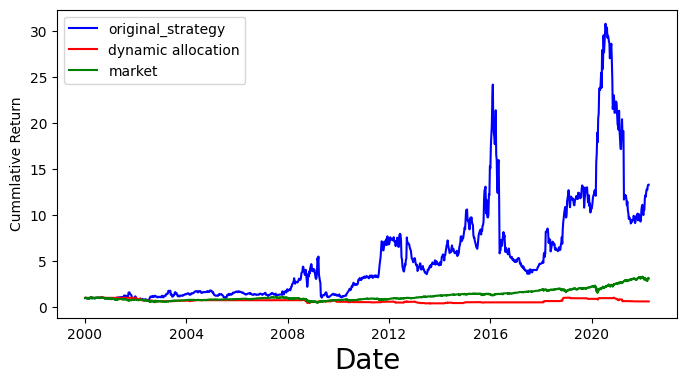

In [109]:
# Backtest the PF
mom_pf_return, mom_pf_value = backtesting_sketch(
                                    stock_return = stock_return.copy(),
                                    etf_return = market_return.copy(),
                                    weight = momStrategy.total_weight.copy(),
                                    resample = 'w-fri'
                                )

# Plot Cummlative Returns of PFs
# Blue-Virtual_PF, Red-Momentum_Based_Weight_Adjusted PF, Green-S&P500

plt.figure(figsize=(8,4))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Cummlative Return", fontsize=10)

plt.plot((pf_return+1).cumprod(), color='blue')
plt.plot((mom_pf_return+1).cumprod(), color='red')
plt.plot((market_return+1).cumprod(), color='green')
plt.legend(['original_strategy', 'dynamic allocation', 'market'])

print("Beta-Asymmetry Strategy")
print("CAGR:", cagr(cum(pf_return)).values)
print("Sharpe:", sharpe(pf_return, days=52).values)
print("MDD:", max_dd(cum(pf_return)))
print("VOL:", cagr(cum(pf_return)).values / sharpe(pf_return[:], days=52).values)

print()
print("Beta-Asymmetry with strategy-based momentum")
print("CAGR:", cagr(cum(mom_pf_return)).values)
print("Sharpe:", sharpe(mom_pf_return, days=52).values)
print("MDD:", max_dd(cum(mom_pf_return)))
print("VOL:", cagr(cum(mom_pf_return)).values / sharpe(mom_pf_return[:], days=52).values)

plt.show()

2000 ~ 2010


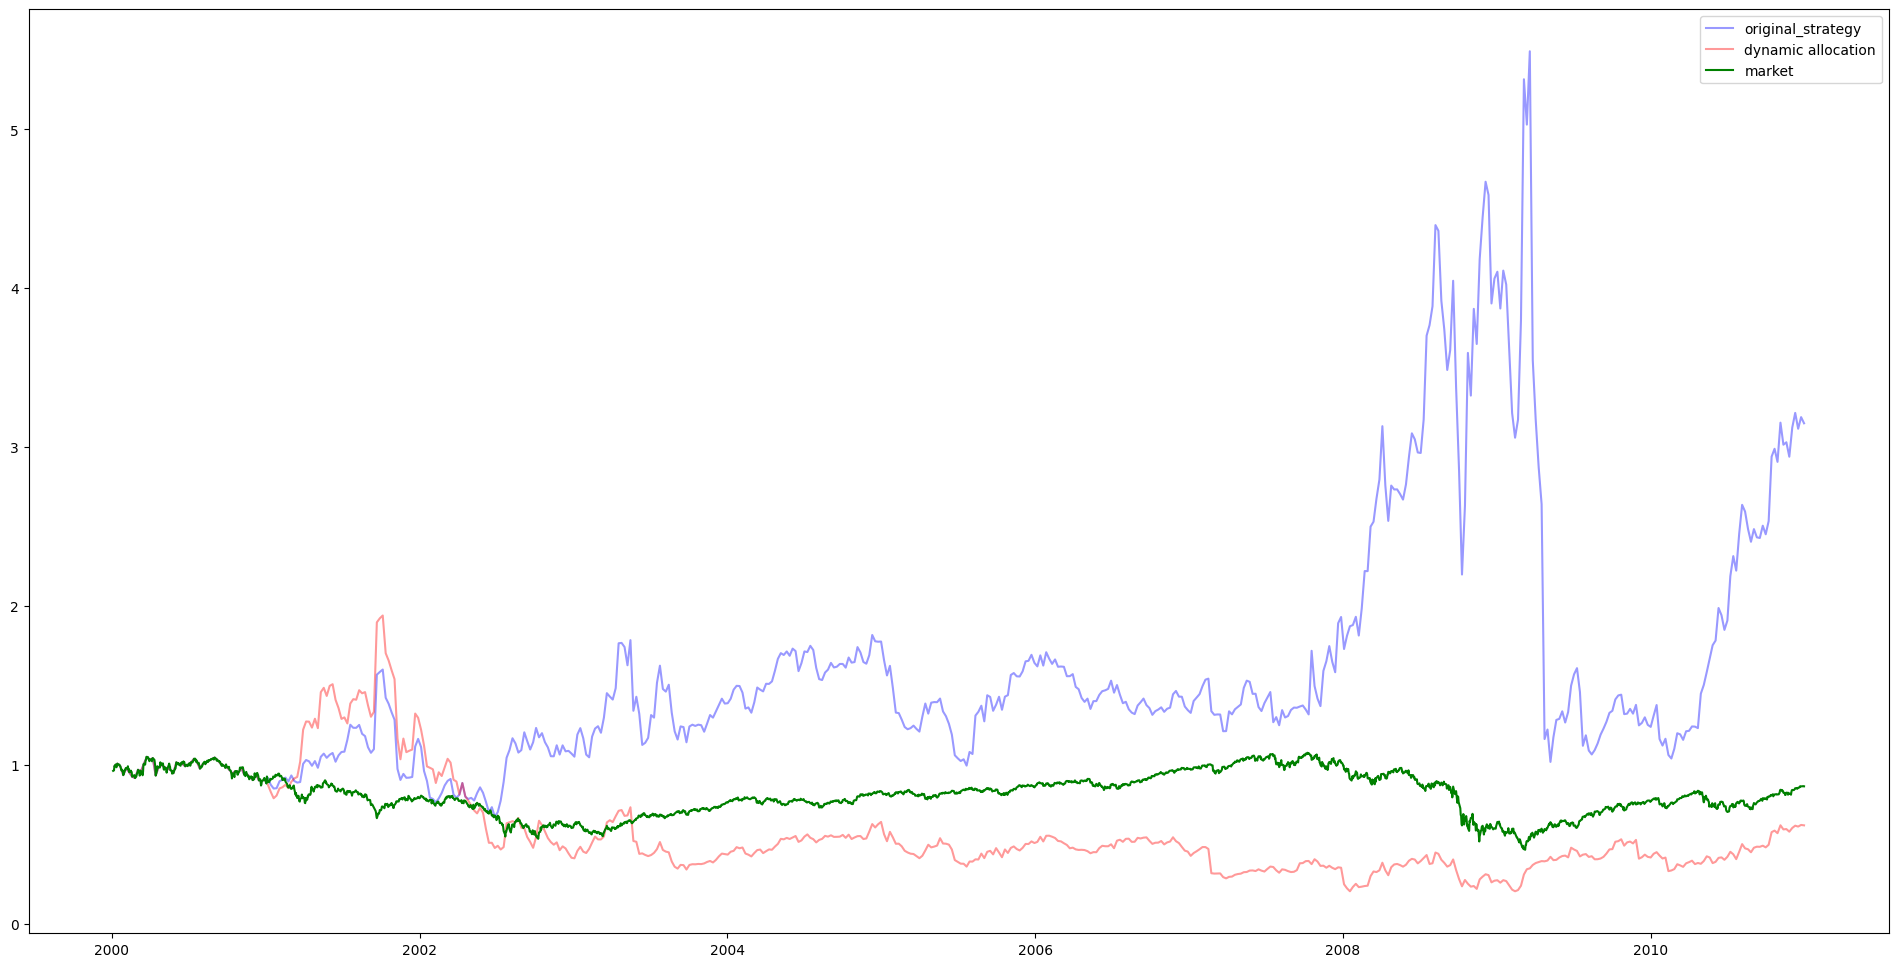

2010 ~ 2020


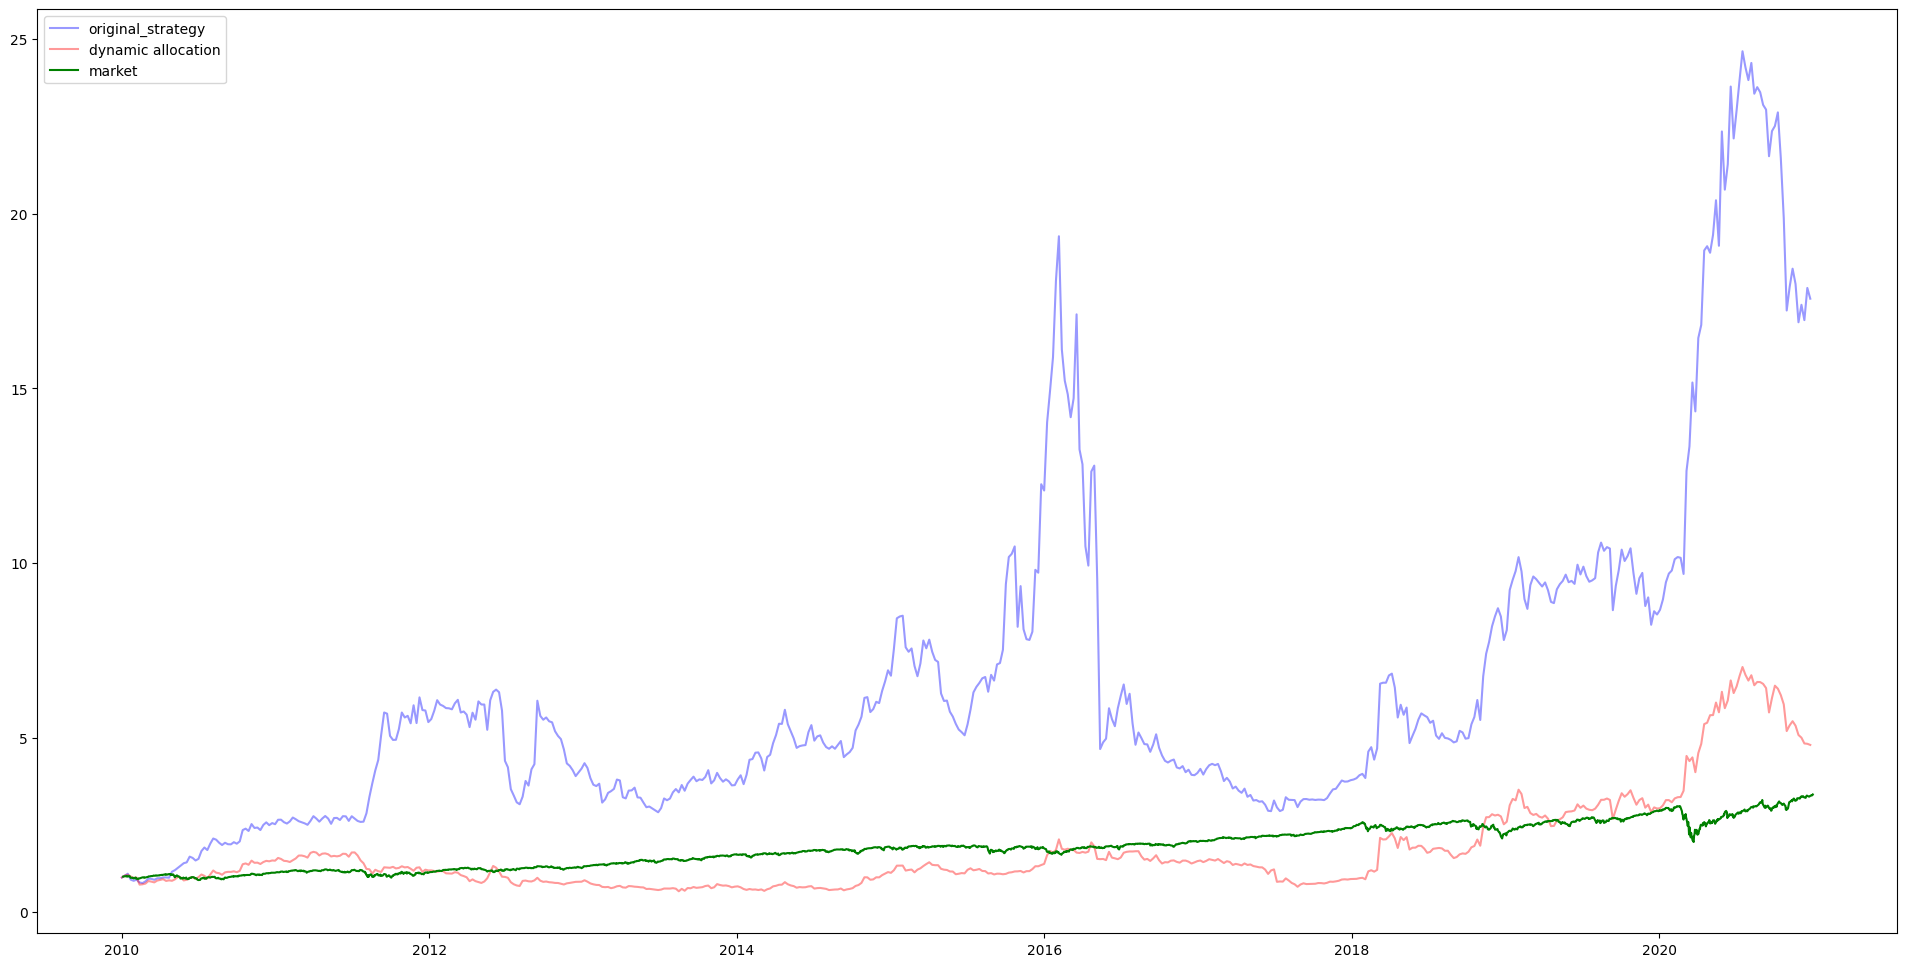

In [29]:
# Visualized the Periodic Performance of Real PF
for start_year in [2000,2010]:
    end_year = str(start_year+10)
    start_year = str(start_year)
    print(start_year, "~", end_year)
    plt.figure(figsize=(24,12))
    plt.plot((pf_return+1)[start_year:end_year].cumprod(), color='blue', alpha=0.4)
    plt.plot((mom_pf_return+1)[start_year:end_year].cumprod(), color='red', alpha=0.4)
    plt.plot((market_return+1)[start_year:end_year].cumprod(), color='green')
    plt.legend(['original_strategy', 'dynamic allocation', 'market'])
    plt.show()

## Korean stock market (KOSPI, KOSDAQ)

In [ ]:
import os, math, copy
import matplotlib.pyplot as plt
from pybeta_asymmetry import *
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Preprocess KR Data
kr_stock = pd.read_csv(loc+"Data/krx_data.csv", index_col=0)
kr_market = pd.read_csv(loc+"Data/krx_market.csv", encoding='cp949')[["일자","종가"]]

# KRX Preprocessing
kr_stock.index = pd.to_datetime(kr_stock.index)

kr_market["일자"] = pd.to_datetime(kr_market["일자"], format="%Y/%m/%d")
kr_market.index = kr_market["일자"]
kr_market = kr_market.drop("일자", axis=1)
kr_market = kr_market.sort_index(ascending=True)

# Preprocess
for idx in kr_market.index:
    if idx not in kr_stock.index:
        kr_market = kr_market.drop(idx, axis=0)

for idx in kr_stock.index:
    if idx not in kr_market.index:
        kr_stock = kr_stock.drop(idx, axis=0)


In [ ]:
backtest(kr_stock, kr_market, screen = pd.DataFrame([[1]*kr_stock.shape[1]]*kr_stock.shape[0], columns=kr_stock.columns, index=kr_stock.index))